In [1]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from skfuzzy import control as ctrl

### Define Input and Output Variables

In [ ]:
pm25 = ctrl.Antecedent(np.arange(0, 151, 1), 'pm25')             # PM2.5 in μg/m³
ozone = ctrl.Antecedent(np.arange(0, 101, 1), 'ozone')           # O3 in ppb
wind_speed = ctrl.Antecedent(np.arange(0, 51, 1), 'wind_speed')  # Wind speed in km/h
humidity = ctrl.Antecedent(np.arange(0, 101, 1), 'humidity')     # Relative humidity in %

health_risk = ctrl.Consequent(np.arange(0, 101, 1), 'health_risk')              # Risk score 0-100
recommended_action = ctrl.Consequent(np.arange(0, 4, 1), 'recommended_action')  # 0-3 scale for actions

### Define Membership Functions

In [ ]:
# --- PM2.5 Levels (μg/m³) ---
pm25['low'] = fuzz.trimf(pm25.universe, [0, 0, 25])
pm25['moderate'] = fuzz.trimf(pm25.universe, [15, 35, 55])
pm25['high'] = fuzz.trimf(pm25.universe, [35, 75, 115])
pm25['very_high'] = fuzz.trapmf(pm25.universe, [75, 115, 150, 150])

# --- Ozone Levels (ppb) ---
ozone['good'] = fuzz.trimf(ozone.universe, [0, 0, 55])
ozone['moderate'] = fuzz.trimf(ozone.universe, [35, 65, 85])
ozone['unhealthy_sensitive'] = fuzz.trapmf(ozone.universe, [65, 85, 100, 100])

# --- Wind Speed (km/h) ---
wind_speed['low'] = fuzz.trimf(wind_speed.universe, [0, 0, 10])
wind_speed['medium'] = fuzz.trimf(wind_speed.universe, [5, 15, 25])
wind_speed['high'] = fuzz.trapmf(wind_speed.universe, [15, 25, 50, 50])

# --- Humidity (%) ---
humidity['low'] = fuzz.trimf(humidity.universe, [0, 0, 40])
humidity['medium'] = fuzz.trimf(humidity.universe, [30, 50, 70])
humidity['high'] = fuzz.trapmf(humidity.universe, [60, 80, 100, 100])

# --- Health Risk Level (0-100) ---
health_risk['low'] = fuzz.trimf(health_risk.universe, [0, 0, 30])
health_risk['moderate'] = fuzz.trimf(health_risk.universe, [20, 45, 70])
health_risk['high'] = fuzz.trimf(health_risk.universe, [50, 75, 90])
health_risk['severe'] = fuzz.trapmf(health_risk.universe, [80, 90, 100, 100])

# --- Recommended Actions (0-3 scale) ---
recommended_action['no_action'] = fuzz.trimf(recommended_action.universe, [0, 0, 0.5])              # 0 = No Action
recommended_action['sensitive_warning'] = fuzz.trimf(recommended_action.universe, [0.5, 1, 1.5])    # 1 = Sensitive Groups Warning
recommended_action['limit_activities'] = fuzz.trimf(recommended_action.universe, [1.5, 2, 2.5])     # 2 = Limit Outdoor Activities
recommended_action['general_warning'] = fuzz.trimf(recommended_action.universe, [2.5, 3, 3])        # 3 = General Population Warning

### Visualize Membership Functions
# pm25.view()
# ozone.view()
# wind_speed.view()
# humidity.view()
# health_risk.view()
# recommended_action.view()

### Define Fuzzy Rules

In [ ]:
# High pollution + poor dispersion conditions = High Risk
rule1 = ctrl.Rule(pm25['high'] | pm25['very_high'] | ozone['unhealthy_sensitive'], 
                 (health_risk['high'], recommended_action['limit_activities']))
rule2 = ctrl.Rule((pm25['high'] | pm25['very_high']) & wind_speed['low'], 
                 (health_risk['severe'], recommended_action['general_warning']))
rule3 = ctrl.Rule((pm25['high'] | pm25['very_high']) & humidity['high'] & wind_speed['low'], 
                 (health_risk['severe'], recommended_action['general_warning']))

# Moderate pollution conditions
rule4 = ctrl.Rule(pm25['moderate'] & ozone['moderate'], 
                 (health_risk['moderate'], recommended_action['sensitive_warning']))
rule5 = ctrl.Rule(pm25['moderate'] & wind_speed['low'], 
                 (health_risk['moderate'], recommended_action['sensitive_warning']))

# Good air quality conditions
rule6 = ctrl.Rule(pm25['low'] & ozone['good'] & (wind_speed['medium'] | wind_speed['high']), 
                 (health_risk['low'], recommended_action['no_action']))
rule7 = ctrl.Rule(pm25['low'] & ozone['good'], 
                 (health_risk['low'], recommended_action['no_action']))

# Mixed conditions with good dispersion
rule8 = ctrl.Rule((pm25['moderate'] | ozone['moderate']) & wind_speed['high'], 
                 (health_risk['low'], recommended_action['no_action']))
rule9 = ctrl.Rule(pm25['high'] & wind_speed['high'], 
                 (health_risk['moderate'], recommended_action['sensitive_warning']))

# Ozone-driven risk
rule10 = ctrl.Rule(ozone['unhealthy_sensitive'] & humidity['high'], 
                  (health_risk['high'], recommended_action['limit_activities']))

# Combine all rules
air_quality_rules = [
    rule1, rule2, rule3, rule4, rule5,
    rule6, rule7, rule8, rule9, rule10
]

### Create Control System

In [ ]:
air_quality_ctrl = ctrl.ControlSystem(rules=air_quality_rules)
air_quality_sim = ctrl.ControlSystemSimulation(air_quality_ctrl)

### Test with hypothetical case study data

In [ ]:
# Store input values separately for display
input_pm25 = 55      
input_ozone = 70      
input_wind_speed = 5   
input_humidity = 75    

# Set inputs and compute
air_quality_sim.input['pm25'] = input_pm25
air_quality_sim.input['ozone'] = input_ozone
air_quality_sim.input['wind_speed'] = input_wind_speed
air_quality_sim.input['humidity'] = input_humidity

# Compute the results
air_quality_sim.compute()

# === Display Results ===
print("=== Urban Air Quality Risk Assessment ===")
print(f"Input Conditions:")
print(f"  PM2.5: {input_pm25} μg/m³")
print(f"  Ozone: {input_ozone} ppb")
print(f"  Wind Speed: {input_wind_speed} km/h")
print(f"  Humidity: {input_humidity}%")
print(f"\nOutput Results:")
print(f"  Health Risk Score: {air_quality_sim.output['health_risk']:.1f}/100")

# Interpret the recommended action
action_value = air_quality_sim.output['recommended_action']
if action_value <= 0.75:
    action_text = "No Action Required"
elif action_value <= 1.75:
    action_text = "Issue Warning for Sensitive Groups"
elif action_value <= 2.5:
    action_text = "Limit Outdoor Activities"
else:
    action_text = "Issue General Population Warning"

print(f"  Recommended Action: {action_text} (Value: {action_value:.2f})")

# Interpret risk level
risk_score = air_quality_sim.output['health_risk']
if risk_score <= 30:
    risk_level = "Low"
elif risk_score <= 60:
    risk_level = "Moderate"
elif risk_score <= 80:
    risk_level = "High"
else:
    risk_level = "Severe"

print(f"  Risk Level: {risk_level}")

=== Urban Air Quality Risk Assessment ===
Input Conditions:
  PM2.5: 55 μg/m³
  Ozone: 70 ppb
  Wind Speed: 5 km/h
  Humidity: 75%

Output Results:
  Health Risk Score: 77.9/100
  Recommended Action: Limit Outdoor Activities (Value: 2.12)
  Risk Level: High


### Plot 3D Surface

In [8]:
# === Create 3D grid for input space ===
# Fix wind speed and humidity, vary PM2.5 and Ozone
fixed_wind_speed = 10   # km/h
fixed_humidity = 60     # %

x, y = np.meshgrid(
    np.linspace(pm25.universe.min(), pm25.universe.max(), 50),   # PM2.5 on x-axis
    np.linspace(ozone.universe.min(), ozone.universe.max(), 50)  # Ozone on y-axis
)
z_health_risk = np.zeros_like(x, dtype=float)
z_recommended_action = np.zeros_like(x, dtype=float)

# === Evaluate the system at each (PM2.5, Ozone) point ===
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        # Create a NEW simulation for each point
        sim = ctrl.ControlSystemSimulation(air_quality_ctrl)
        sim.input['pm25'] = x[i, j]
        sim.input['ozone'] = y[i, j]
        sim.input['wind_speed'] = fixed_wind_speed
        sim.input['humidity'] = fixed_humidity
        try:
            sim.compute()
            z_health_risk[i, j] = sim.output['health_risk']
            z_recommended_action[i, j] = sim.output['recommended_action']
        except Exception as e:
            # Handle cases where no rules fire
            z_health_risk[i, j] = 0
            z_recommended_action[i, j] = 0

Plotting with fixed values: Wind Speed = 10 km/h, Humidity = 60%


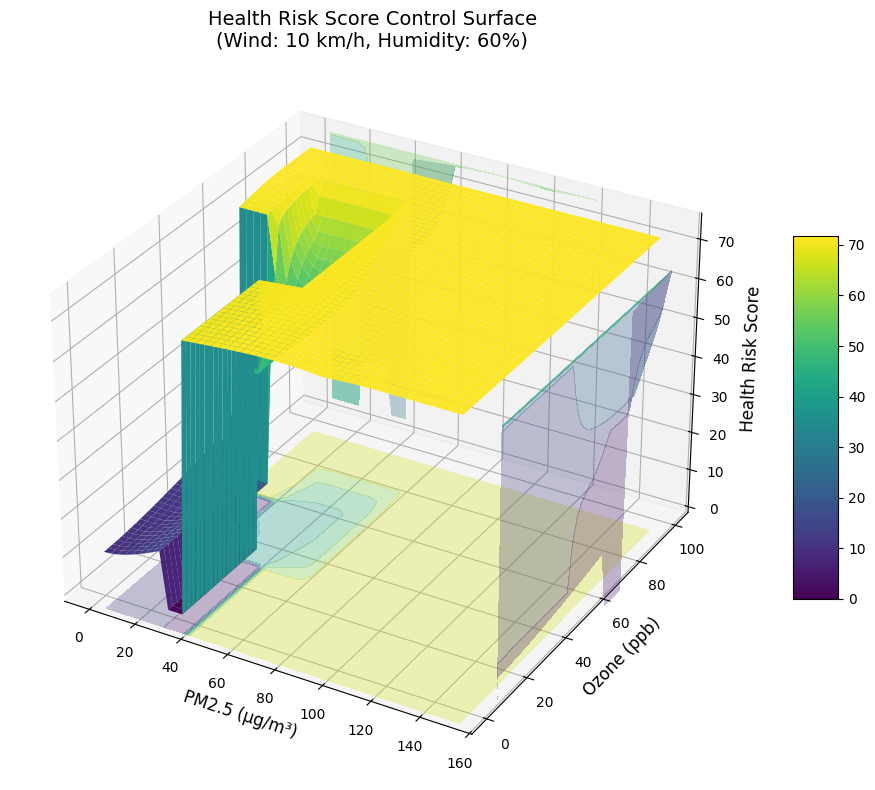

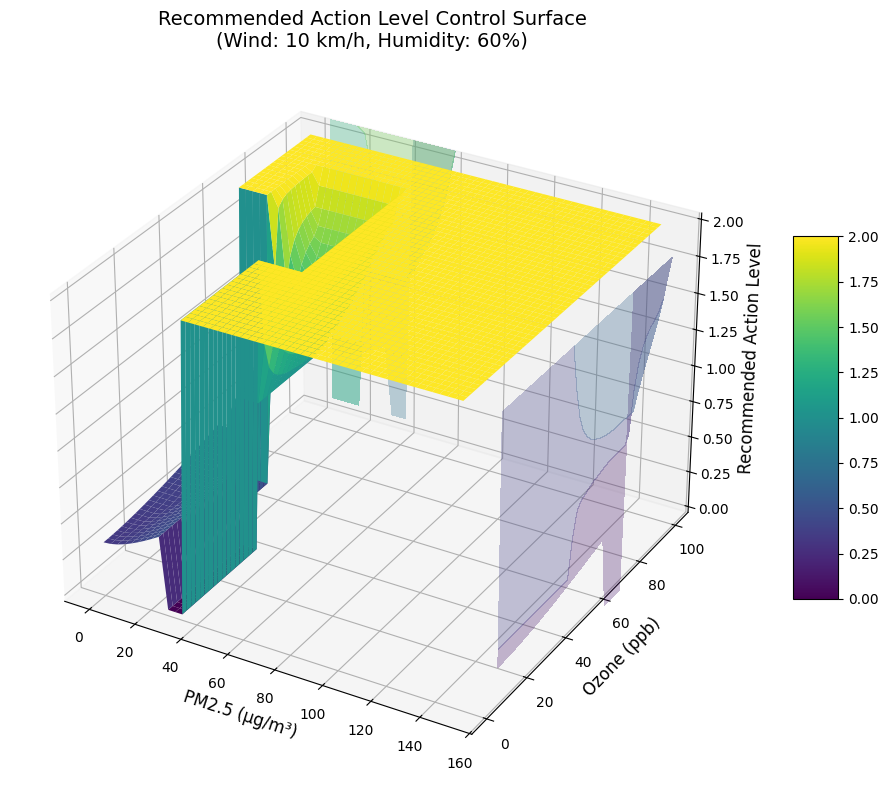

In [25]:
# === Define 3D plotting helper ===
def plot3d_air_quality(x, y, z, title, xlabel='PM2.5 (μg/m³)', ylabel='Ozone (ppb)'):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, y, z, rstride=1, cstride=1,
                           cmap='viridis', linewidth=0.4, antialiased=True)

    # Add contour projections
    ax.contourf(x, y, z, zdir='z', offset=z.min()-5, cmap='viridis', alpha=0.3)
    ax.contourf(x, y, z, zdir='x', offset=x.max()*1.1, cmap='viridis', alpha=0.3)
    ax.contourf(x, y, z, zdir='y', offset=y.max()*1.1, cmap='viridis', alpha=0.3)

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_zlabel(title, fontsize=12)
    ax.set_title(f'{title} Control Surface\n(Wind: {fixed_wind_speed} km/h, Humidity: {fixed_humidity}%)', fontsize=14)
    fig.colorbar(surf, shrink=0.5, aspect=8)
    plt.tight_layout()
    plt.show()

# === Plot both control surfaces ===
print(f"Plotting with fixed values: Wind Speed = {fixed_wind_speed} km/h, Humidity = {fixed_humidity}%")
plot3d_air_quality(x, y, z_health_risk, "Health Risk Score")
plot3d_air_quality(x, y, z_recommended_action, "Recommended Action Level")

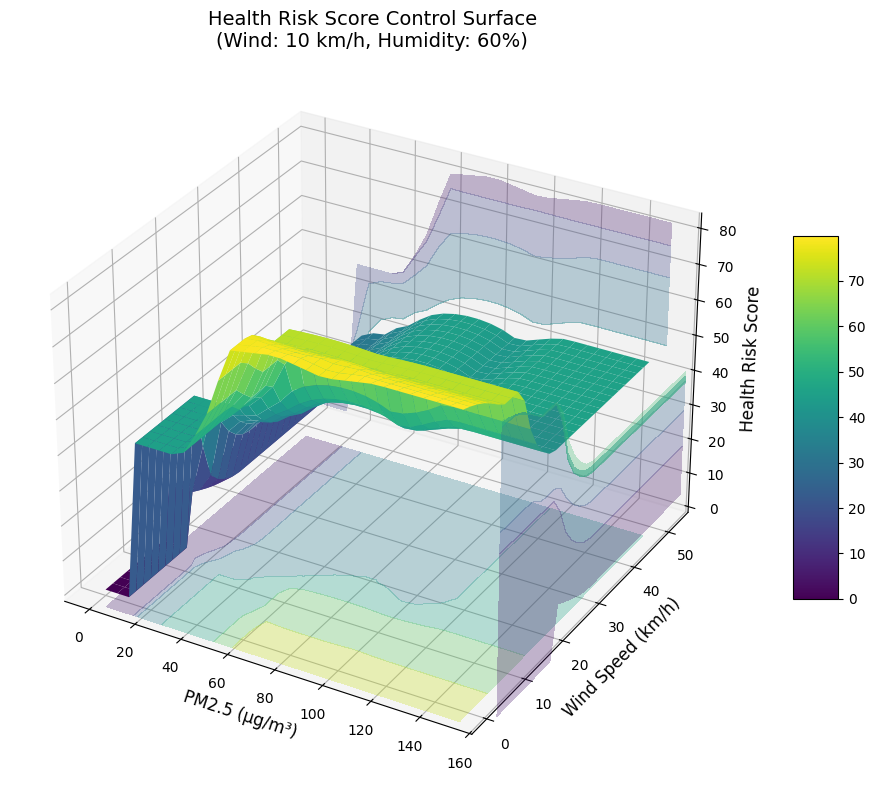

In [26]:
# === Alternative: PM2.5 vs Wind Speed ===
# Fix ozone and humidity, vary PM2.5 and wind speed
fixed_ozone = 60       # ppb
fixed_humidity = 60    # %

x, y = np.meshgrid(
    np.linspace(pm25.universe.min(), pm25.universe.max(), 30),      # PM2.5 on x-axis
    np.linspace(wind_speed.universe.min(), wind_speed.universe.max(), 30)  # Wind Speed on y-axis
)
z_health_risk = np.zeros_like(x, dtype=float)

for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        sim = ctrl.ControlSystemSimulation(air_quality_ctrl)
        sim.input['pm25'] = x[i, j]
        sim.input['ozone'] = fixed_ozone
        sim.input['wind_speed'] = y[i, j]
        sim.input['humidity'] = fixed_humidity
        try:
            sim.compute()
            z_health_risk[i, j] = sim.output['health_risk']
        except:
            z_health_risk[i, j] = 0

plot3d_air_quality(x, y, z_health_risk, "Health Risk Score", 
                   xlabel='PM2.5 (μg/m³)', ylabel='Wind Speed (km/h)')

### Test Multiple Scenarios

In [ ]:
print("\n=== Testing Multiple Scenarios ===")

test_scenarios = [
    {"pm25": 15, "ozone": 40, "wind": 20, "humidity": 50, "desc": "Good day"},
    {"pm25": 45, "ozone": 70, "wind": 8, "humidity": 65, "desc": "Moderate pollution, low wind"},
    {"pm25": 80, "ozone": 90, "wind": 5, "humidity": 80, "desc": "High pollution, stagnant conditions"},
]

for scenario in test_scenarios:
    air_quality_sim.input['pm25'] = scenario["pm25"]
    air_quality_sim.input['ozone'] = scenario["ozone"]
    air_quality_sim.input['wind_speed'] = scenario["wind"]
    air_quality_sim.input['humidity'] = scenario["humidity"]
    
    air_quality_sim.compute()
    
    risk_score = air_quality_sim.output['health_risk']
    action_value = air_quality_sim.output['recommended_action']
    
    # Determine risk level
    if risk_score <= 30:
        risk_level = "Low"
    elif risk_score <= 60:
        risk_level = "Moderate"
    elif risk_score <= 80:
        risk_level = "High"
    else:
        risk_level = "Severe"
    
    # Determine action
    if action_value <= 0.75:
        action_text = "No Action"
    elif action_value <= 1.75:
        action_text = "Sensitive Groups Warning"
    elif action_value <= 2.5:
        action_text = "Limit Activities"
    else:
        action_text = "General Warning"
    
    print(f"\nScenario: {scenario['desc']}")
    print(f"  PM2.5: {scenario['pm25']}, O3: {scenario['ozone']}, Wind: {scenario['wind']}, Humidity: {scenario['humidity']}")
    print(f"  Result: {risk_level} Risk ({risk_score:.1f}), Action: {action_text}")